# Introduction to Agents and Workflows in AI

- **Agent**:  
  An autonomous system that uses AI to achieve goals by interacting with its environment and making decisions.

- **Workflow**:  
  A sequence of tasks or processes that guide the agent's actions to achieve specific outcomes.

---

- **Key Points**:  
  - Agents operate within workflows to perform tasks efficiently and effectively.  
  - Workflows can be simple (linear steps) or complex (branched, iterative).  
  - Well-designed workflows enhance agent performance, accuracy, and transparency.

---

> **Visual Representation**:  
> ![Agent Workflow](https://langchain-ai.github.io/langgraph/concepts/img/agent_workflow.png)  
> _A simple workflow where the agent processes tasks in sequence to produce an output._

To get started, you'll need an API key from your provider of choice, such as **https://www.aibrary.dev**, **https://unify.ai/**, **https://openrouter.ai/**, **https://www.openai.com**, or others. Follow these steps to obtain one:

1. **Sign up or log in** to your selected provider's platform.
2. **Navigate** to the API or developer section (often found in the dashboard or settings).
3. **Create a new API key** by locating the option to generate or request one.
4. **Follow the prompts** to finalize the process—this might include agreeing to terms or providing additional details.
5. **Copy your API key** once it’s generated and store it securely. **Never share it publicly.**


## Install Requirements
`pip install -r requirements.txt`


In [11]:
%%capture
%pip install langgraph langchain langchain_openai

In [ ]:
import getpass
from langchain_openai import ChatOpenAI
import os
def get_api_key(var: str):
    if not os.environ.get(var):
        return getpass.getpass(f"{var}: ")
    else:
        return os.environ.get(var)


API_KEY = get_api_key("API_KEY")
llm = ChatOpenAI(model="gpt-4o@openai", base_url="https://api.unify.ai/v0", api_key=API_KEY)
llm.invoke("Hello how are you?")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 12, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'cost': 0.00033}, 'model_name': 'gpt-4o@openai', 'system_fingerprint': None, 'id': 'chatcmpl-BY6LkiJEDoCWhZllYtYz2zrTsrlVv', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--3ab83d07-cffa-42c6-b487-137c64516d4b-0', usage_metadata={'input_tokens': 12, 'output_tokens': 30, 'total_tokens': 42, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# The Augmented LLM for News Summarization

## Use Case:
Tasks needing extra capabilities beyond text generation, like accessing external data or tools.

## Structure:
A single LLM enhanced with features like retrieval-augmented generation (RAG), tool usage, or memory.

## Why Use It:
Simple and versatile for tasks requiring external information or interaction, without complex setups.

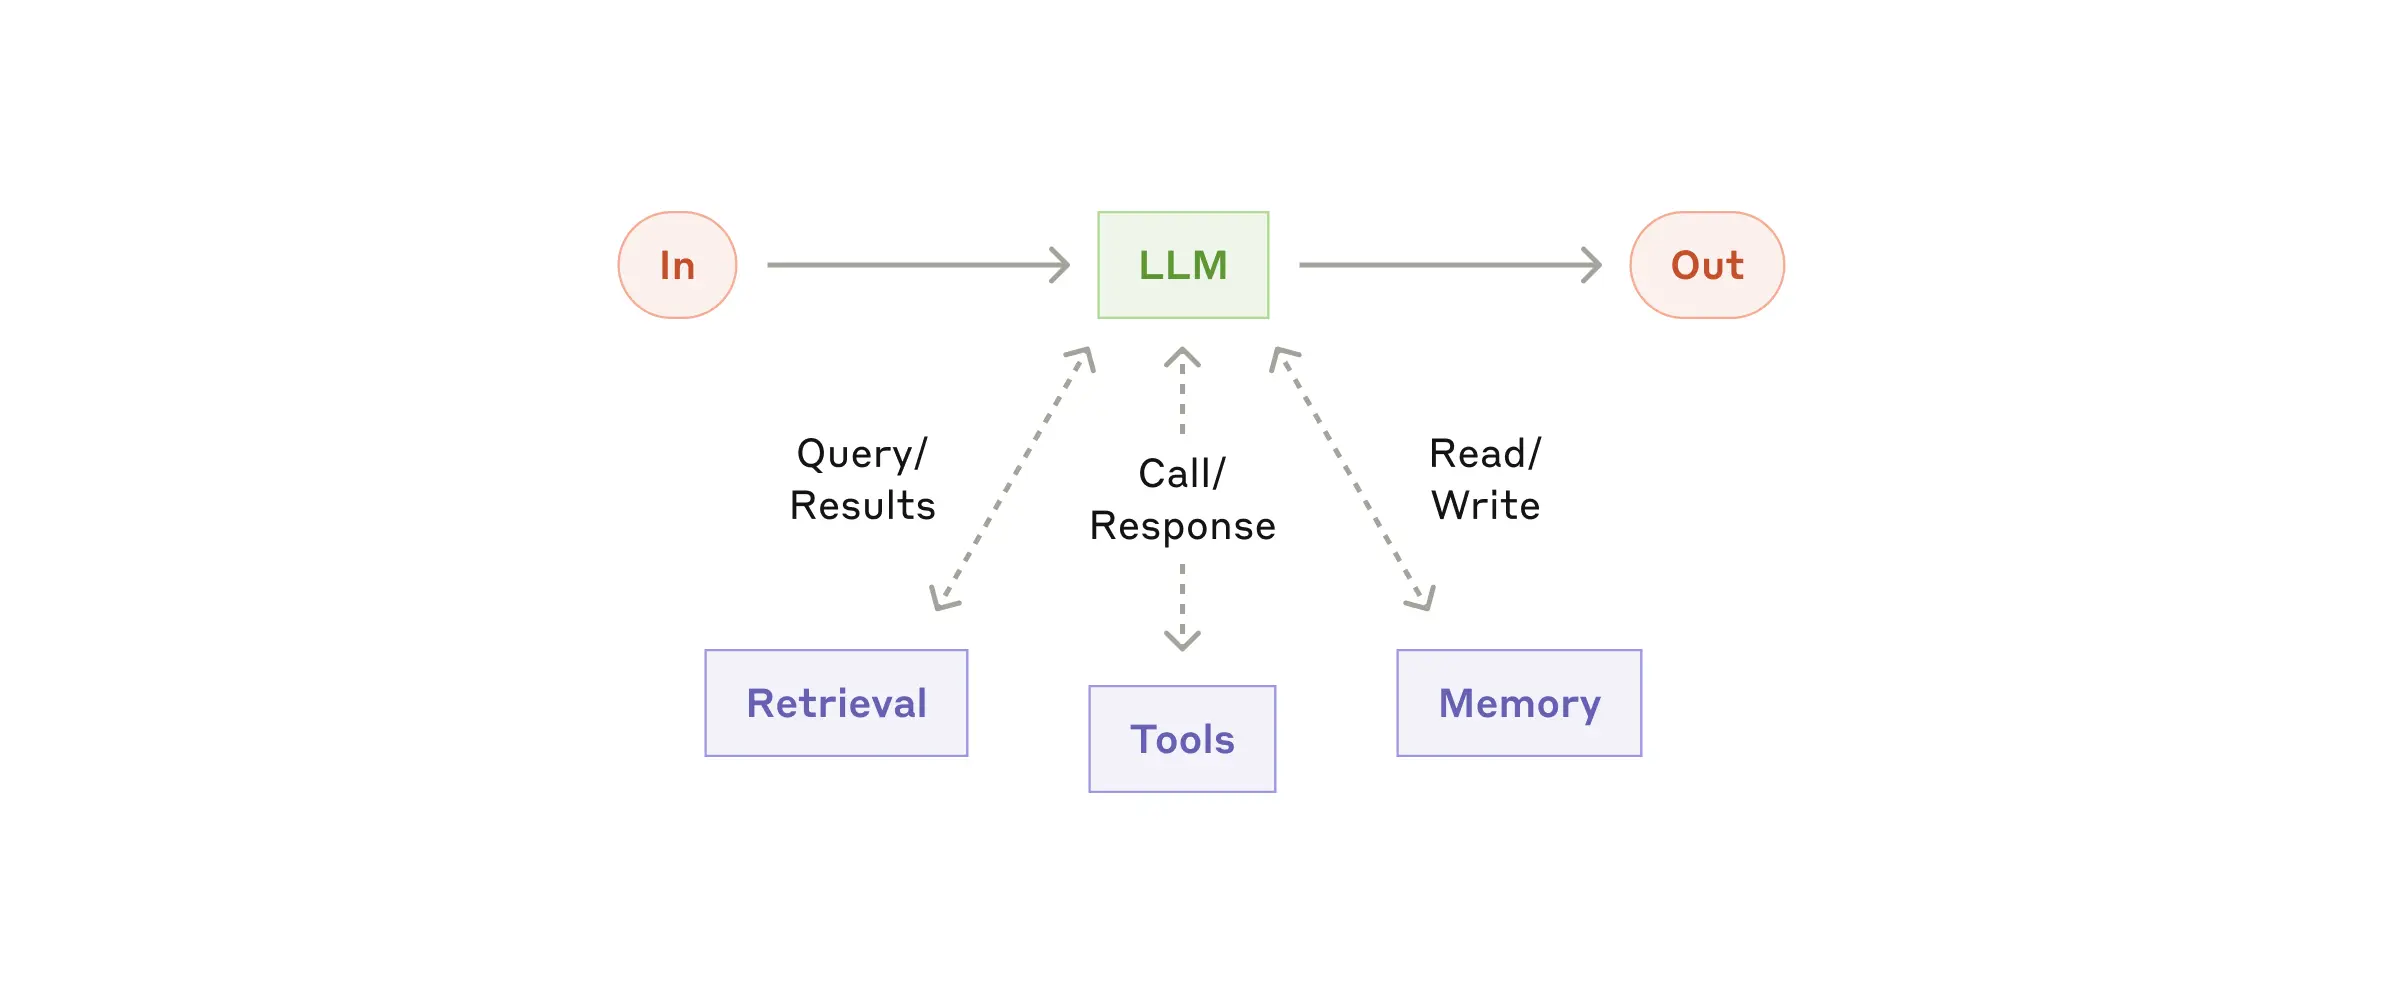


In [65]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# Define your desired data structure.
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")


# And a query intented to prompt a language model to populate the data structure.
joke_query = "Tell me a joke."

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=Joke)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

chain.invoke({"query": joke_query})


{'setup': "Why don't scientists trust atoms?",
 'punchline': 'Because they make up everything!'}

In [66]:

def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls


[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_Ehi8xL4IjOF1RsdwbsioFL4E',
  'type': 'tool_call'}]

# Prompt Chaining

## Use Case:
Complex tasks that can be broken into clear, sequential steps.

## Structure:
A series of LLM prompts where each output feeds into the next, often with quality checks.

## Why Use It:
Improves control and accuracy by structuring tasks into manageable, logical stages.

![Chaining](https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F7418719e3dab222dccb379b8879e1dc08ad34c78-2401x1000.png&w=3840&q=75)


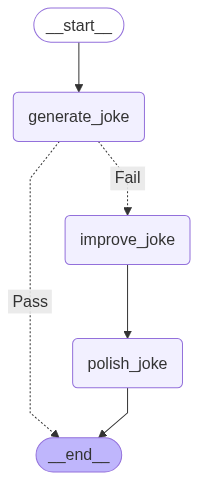

Initial joke:
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Joke failed quality gate - no punchline detected!


In [67]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

# Routing

## Use Case:
Diverse inputs needing specialized handling based on their type or category.

## Structure:
Inputs are classified and directed to specific models or handlers tailored to each category.

## Why Use It:
Enhances efficiency and precision by matching inputs to the most suitable processing component.

![Routing](https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F5c0c0e9fe4def0b584c04d37849941da55e5e71c-2401x1000.png&w=3840&q=75)

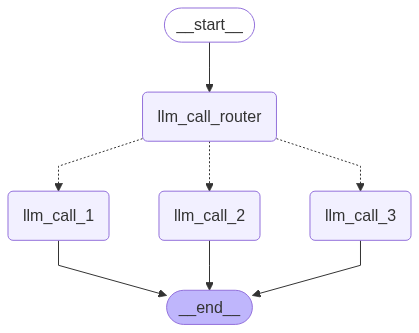

Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


In [68]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
# router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    parser = JsonOutputParser(pydantic_object=Route)
    prompt = PromptTemplate(
        template="Route the input to story, joke, or poem based on the user's request.\n{format_instructions}\n{query}\n",
        input_variables=["query"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | llm | parser

    decision = chain.invoke({"query": state["input"]})

    return {"decision": decision["step"]}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

# Parallelization

## Use Case:
Tasks with independent subtasks or needing multiple outputs for reliability.

## Structure:
Multiple LLM calls run simultaneously, with results aggregated or selected.

## Why Use It:
Speeds up processing and can improve reliability by combining or comparing outputs.

![Parallelization](https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F406bb032ca007fd1624f261af717d70e6ca86286-2401x1000.png&w=3840&q=75)

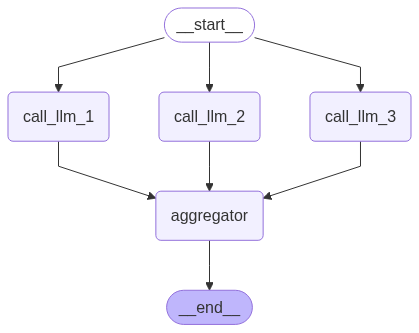

Here's a story, joke, and poem about cats!

STORY:
In the quiet town of Eldergrove, nestled between rolling hills and ancient oak trees, there was a peculiar legend known to all its residents—young and old alike. It was the story of The Midnight Parade of Cats.

The tale began with a quaint little shop named "Whiskers & Wonders." Owned by an endearing woman named Miss Celia, the shop sold everything from intriguing trinkets to peculiar potion ingredients. But what made Whiskers & Wonders truly special was the presence of its feline residents, a group of twenty-three cats, each with its own unique personality and charm.

Miss Celia had a special way with cats; it was as if she could converse with them, understanding their purrs and meows in ways that no one else could. The cats, in turn, seemed to share an unbreakable bond not just with her, but also with each other, and, more curiously, with the town itself.

Every night, as the clock approached midnight, the air would fill with a stra

In [69]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

# Orchestrator-Workers for Task Delegation

## Use Case:
Complex tasks requiring dynamic planning and coordination of subtasks.

## Structure:
A central LLM (orchestrator) assigns subtasks to worker LLMs and combines results.


## Why Use It:
Flexible and scalable for unpredictable or multifaceted problems needing adaptive handling.

![Orchestrator](https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F8985fc683fae4780fb34eab1365ab78c7e51bc8e-2401x1000.png&w=3840&q=75)

In [73]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

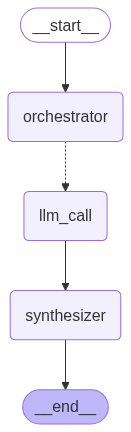

## Introduction

Large Language Models (LLMs) are advanced artificial intelligence systems crafted primarily for processing and generating human language. They represent a breakthrough in the field of natural language processing (NLP), enabling computers to understand, interpret, and generate human-like text with remarkable accuracy. These models are trained on vast datasets encompassing diverse languages, contexts, and subjects, allowing them to perform a wide range of language-based tasks such as text generation, translation, summarization, and question answering.

The significance of LLMs in the NLP and artificial intelligence fields cannot be overstated. They have transformed traditional methods of processing language by providing a more nuanced, contextual, and dynamic understanding of text. This transformation is largely due to their ability to learn from extensive datasets, capturing subtle patterns and context in a way that mimics human cognition more closely than previous models. As a result, LLMs have become essential tools in developing applications that require nuanced human interaction, such as chatbots, virtual assistants, and language-based educational tools.

Scalability and efficiency are critical aspects of LLMs, dictating their performance and practical application. As the size and complexity of these models increase, they require sophisticated infrastructure to support their operations. Ensuring that AI systems maintain efficiency as they scale is vital for real-time processing and generating output within acceptable timeframes. Furthermore, scalable models are able to cater to growing data and time demands, thus expanding their applicability across different industries.

In summary, Large Language Models stand at the forefront of NLP and AI research due to their unparalleled ability to understand and generate human language. Their continued development hinges on overcoming challenges related to scalability and efficiency, paving the way for more refined and contextually aware AI-driven language applications.

---

### Understanding Scaling Laws

Scaling laws are theoretical principles that describe how the performance of large language models (LLMs) scales with various factors, including the size of the model, the volume of training data, and the computational power utilized during training. These laws are critical for understanding and predicting the behavior and capabilities of LLMs as they are expanded and trained on more extensive datasets.

#### Theoretical Aspects

The foundation of scaling laws lies in their ability to provide a mathematical framework that forecasts the relationship between resource input and model performance. This involves:

1. **Model Size**: Scaling laws suggest that as the number of parameters in a model increases, the model's capability to learn and generalize from data also improves. Theoretically, larger models can capture more complex patterns, but this is contingent upon appropriate training strategies to avoid overfitting and underutilization of model capacity.

2. **Dataset Size**: There's a direct correlation between dataset size and model performance. Theoretically, scaling the amount of diverse and high-quality data enables models to understand and generalize better, thus enhancing performance measures like accuracy or fluency in language tasks.

3. **Compute Resources**: Compute power, encompassing both the hardware used for training and the algorithms that optimize training processes, scales model performance. Theoretical scaling laws highlight that sufficient computational resources enable deeper and more effective exploration of parameter space, yielding robust and generalizable models.

#### Practical Aspects

In practice, scaling laws are instrumental in strategic decision-making during model development and deployment:

1. **Performance Prediction**: By applying scaling laws, practitioners can predict the expected performance of models as they increase in size or are provided with more extensive datasets. This predictive capability helps in planning resource allocation effectively, ensuring that the expected gains justify the investment in compute and data resources.

2. **Resource Management**: Scaling laws inform the necessary balance between model size, training data, and computational power to optimize performance efficiently. This balance is crucial in practical applications where computational constraints and cost-effectiveness are significant considerations.

3. **Empirical Validation**: Although primarily theoretical, scaling laws have been empirically validated across various models and datasets. These validations help refine the laws, making them more robust and reliable as tools for model scaling predictions.

4. **Guiding Optimization**: As organizations leverage scaling laws to guide the development of state-of-the-art LLMs, they also use insights derived from these laws to optimize hyperparameters and training regimes, further enhancing model performance without disproportionately scaling costs.

By leveraging the insights from scaling laws, researchers and practitioners can better strategize the development and deployment of LLMs, ensuring that the expansion of models aligns with performance improvements and resource utilization goals.

---

## Historical Context

The study of scaling laws has been pivotal in advancing the understanding of complex systems across various scientific domains. This section explores the evolution of these laws, highlighting key developments and contributions that have shaped current perspectives.

### Early Foundations

The concept of scaling laws dates back to early 20th-century physics, where researchers explored relationships involving simple power laws. In 1936, Kapteyn's work on stellar surfaces established early applications of scaling laws in astrophysics. However, it wasn't until the 1980s that the field gained significant traction.

### Key Developments

**1980 - Fractals and Self-Similarity:**
Benoit Mandelbrot's seminal work "The Fractal Geometry of Nature," published in 1982, introduced the concept of fractals, highlighting self-similarity and intricate patterns at different scales. This work laid the groundwork for understanding complex structures in nature as scale-invariant.

**1985 - Renormalization Group Theory:**
The development of Renormalization Group Theory by Kenneth Wilson significantly advanced the application of scaling laws in statistical physics. This theory provided a framework for understanding critical phenomena and phase transitions, linking scaling behaviors with macroscopic properties.

**1999 - Power Laws in Networks:**
Albert-László Barabási and Réka Albert's groundbreaking paper, "Emergence of Scaling in Random Networks," published in 1999, introduced the scale-free network model. They demonstrated that many natural and man-made networks, such as the Internet and biological systems, exhibit power-law degree distributions, reshaping our comprehension of network dynamics.

### Advances in Machine Learning

The modern era of scaling laws saw a transformational shift with their application in machine learning and artificial intelligence.

**2017 - Deep Learning and Neural Scaling:**
The work of Hestness et al. unveiled empirical insights into how training data size impacts the performance of deep learning models. Published in the paper "Deep Learning Scaling is Predictable, Empirically," it empirically validated scaling laws in the context of neural networks.

**2020 - Scaling Laws for Language Models:**
The research conducted by Kaplan et al. introduced systematic scaling laws for AI model capabilities and resource requirements. Their study, "Scaling Laws for Neural Language Models," provided quantitative predictions about how model performance improves with increased dataset size, model parameters, and compute power.

### Recent Insights

**2022 - Beyond Language Models:**
The extension of scaling laws beyond language models marked a critical expansion of their applicability. Papers exploring multi-modal models and different architectures indicated that scaling principles hold across a variety of data types and tasks.

### Conclusion

The evolution of scaling laws over the decades showcases an interdisciplinary journey from fractals to neural networks. The continuous refinement and application of these laws have yielded profound insights, aiding in the understanding and optimization of complex systems. As research progresses, scaling laws will undoubtedly remain a cornerstone in the advancement of scientific and technological frontiers.

---

## Key Components of Scaling Laws

Scaling laws in machine learning are critical for understanding the relationships between a model's size, the size of the training dataset, and the computational resources required. These components are interdependent and collectively influence the model's performance. Below, we delve into each component and explore how they contribute to scaling laws.

### Model Size (Number of Parameters)

The model size is typically measured by the number of parameters, which are the learnable elements within a neural network. Larger models with more parameters have the potential to capture more complex patterns in data, leading to improved performance. However, increasing the number of parameters also raises the risks of overfitting, where the model becomes too tailored to the training data and performs poorly on unseen data.

- **Trade-offs**: While larger models can potentially reach higher accuracy, they require more data and computational resources to train effectively. As a result, the optimal model size depends on the balance of available data and compute power.
  
- **Performance Plateau**: There is often a point of diminishing returns where merely adding more parameters does not yield significant performance improvements. This is a critical consideration for efficient architecture design.

### Training Dataset Size

The size and quality of the training dataset significantly influence a model's performance. Generally, larger datasets allow models to learn broader and more generalizable patterns, leading to more robust and accurate predictions.

- **Data Efficiency**: With larger datasets, the need for extremely complex models may decrease as simpler models can sufficiently capture the nuances present within the data. Conversely, smaller datasets may necessitate more sophisticated architectures to extract adequate signals from limited information.

- **Data Availability**: The ability to train on larger datasets is often constrained by the practical challenges of data collection, storage, and processing. These limitations directly impact how far scaling laws can be pushed.

### Computational Resources

The computation required for training and validating models comprises hardware infrastructure (e.g., GPUs or TPUs) and the time necessary to perform these tasks. As model size and dataset size increase, the demand for computational resources escalates.

- **Resource Constraints**: Scalability is often limited by the availability of powerful hardware and the financial investment necessary for their acquisition and maintenance. Efficient use of resources through optimization and parallelism is crucial for managing these costs.

- **Energy Consumption**: The computation needed for scaling deep learning models represents a notable energy consumption. This impacts the sustainability of deploying increasingly larger models and motivates the search for more efficient architectures.

### Interrelationships and Contributions to Model Performance

These three components—model size, dataset size, and computational resources—are intricately linked. Their interdependencies determine how effectively a model learns and generalizes:

- **Balance and Optimization**: Achieving optimal performance hinges on balancing these factors. A model might be scaled in terms of parameters, but without sufficient data, its potential is underutilized. Similarly, even with extensive data, inadequate computational resources could bottleneck training times and effectiveness.

- **Innovations in Scaling**: Recent advancements, such as transfer learning and fine-tuning pre-trained models, have shifted the focus partially from scaling unprecedentedly large models to leveraging existing models efficiently, thereby challenging traditional scaling law paradigms.

Advancements in understanding scaling laws continue to drive the development of more effective and efficient machine learning systems. The key is to strategically scale these components to achieve an optimal balance that maximizes both model accuracy and practical feasibility.

---

## Empirical Evidence

Numerous empirical studies and experiments have tested and validated scaling laws, offering valuable insights into their applicability and limitations across various scientific domains. This section reviews pivotal studies that have contributed to our understanding of scaling laws, emphasizing key findings and insights that have emerged.

### Key Empirical Studies

1. **Biological Scaling Laws**
   - **Study by West, Brown, and Enquist (1997):** This foundational study examined the scaling laws in biological systems, particularly the relationship between organism size and metabolic rate. The authors proposed that metabolic rate scales to the 3/4 power of the body mass, a finding that has been validated across numerous species. This scaling relationship has profound implications for understanding the constraints on biological growth and energy usage.
   
   - **Allometric Scaling in Mammals:** Studies across different mammalian species have consistently demonstrated that life history traits such as longevity, reproductive rates, and growth patterns scale predictably with body size. These relationships have reinforced the utility of allometric scaling laws in predicting biological parameters.

2. **Urban Scaling Laws**
   - **Bettencourt et al. (2007):** This study investigated how various characteristics of cities, such as infrastructure, economic indicators, and social dynamics, scale with population size. The researchers discovered that both economic productivity and innovation scale superlinearly, meaning they increase at a faster rate than population growth, while infrastructure scales sublinearly. These findings have significant implications for urban planning and sustainability.
   
   - **Impact of Population Density on Urban Metabolism:** Subsequent studies have built on this work by examining the impact of population density on resource consumption and waste production, highlighting efficient resource use in larger urban centers due to favorable scaling effects.

3. **Technological Scaling Laws**
   - **Moore’s Law:** Named after Gordon Moore, this observation about the doubling of transistors on integrated circuits approximately every two years illustrates a well-known scaling phenomenon in technology. Empirical studies tracking semiconductor advancements have validated this trend over several decades, underscoring the rapid pace of technological advancement.
   
   - **Waldrop (2016) on Photolithography:** Through rigorous examination of the photolithography process in chip manufacturing, researchers have identified scaling constraints and opportunities, offering insights into potential future extensions or adaptations of Moore's Law.

### Insights Gained

- **Universality vs. Specificity:** The verification of scaling laws across diverse domains such as biology, urban studies, and technology reveals both the universality of scaling phenomena and domain-specific variations. This duality suggests that while certain scaling patterns are applicable universally, domain-specific constraints and dynamics must be considered in detailed analyses.

- **Predictive Power and Utility:** Scaling laws provide powerful tools for predicting system behavior across scales, facilitating not only scientific understanding but also practical applications in areas such as resource management, urban planning, and technological forecasting.

- **Constraints and Limitations:** While empirical evidence supports the robustness of scaling laws, studies also highlight their limitations, particularly in systems exhibiting non-linear dynamics or threshold effects that deviate from predictable scaling patterns.

### Conclusion

Empirical validation of scaling laws across diverse fields demonstrates their applicability and utility, while also highlighting the need for a nuanced understanding of their limitations. Continued exploration and empirical testing are essential to refine these laws and enhance their predictive capabilities in increasingly complex systems.

---

### Challenges and Limitations

Scaling laws in machine learning provide immense benefits by delineating how model performance improves with increases in data, compute, and model parameters. However, the application of these laws is not without significant challenges and limitations. The following are key concerns associated with scaling laws:

#### Diminishing Returns

While scaling up models generally leads to improved performance, the gains are often subject to the law of diminishing returns. As models grow, the incremental benefits from adding more parameters or data tend to decrease. This phenomenon limits the utility of scaling laws when it comes to predicting performance gains, as predictions may become unreliable or erratic beyond a certain scale. It suggests a saturation point where additional investment in computational resources yields minimal performance improvement compared to earlier stages of model scaling.

#### Environmental Impact

The scaling of models comes at a significant environmental cost due to the exponential increase in computational resources required. Large-scale models necessitate massive datasets and extensive computational power, which contribute to higher energy consumption and carbon emissions. The energy footprint of training expansive models can be substantial, raising concerns about sustainability and the ecological responsibility of organizations pursuing such ventures. This environmental impact necessitates the development of more efficient algorithms and hardware, as well as a shift towards renewable energy sources to mitigate the carbon footprint associated with large-scale model training.

#### Potential Biases in Large-Scale Models

As models scale, the potential for inherent biases increases, both in the data used and the model's learned representations. Biases in training data can lead to models that replicate or even exacerbate societal biases, leading to unfair or inaccurate outcomes. Large-scale models may further embed these biases, making them more challenging to detect and mitigate. Furthermore, the complexity of such models can obscure accountability, as understanding the reasoning behind specific model decisions becomes more difficult. Addressing these biases necessitates robust methodologies to audit and refine models continuously, alongside diverse and inclusive data sourcing practices.

In conclusion, while scaling laws present an attractive roadmap for enhancing model capabilities, they are accompanied by critical challenges and limitations that must be addressed. Navigating these issues requires a balance between leveraging the benefits of scaling and fostering responsible and sustainable AI development practices.

---

### Applications and Implications

The scaling laws of large language models (LLMs) play a crucial role in determining their performance across various practical applications. By understanding these scaling laws, which relate model size, dataset size, and computational power, researchers and developers can optimize the deployment of LLMs in multiple domains, enhancing efficiency and effectiveness.

#### Practical Applications

1. **Healthcare:**
   - **Diagnostics and Decision Support:** LLMs like GPT-4 can analyze vast amounts of medical literature and patient data to provide enhanced diagnostic support and personalized medicine recommendations. Scaling up these models allows for more accurate pattern recognition and prediction of rare conditions.
   - **Patient Interaction:** In telemedicine, large-scale LLMs facilitate more natural and responsive patient interactions, offering preliminary assessments and answering queries, reducing the burden on healthcare professionals.

2. **Finance:**
   - **Risk Management:** LLMs can process and interpret complex financial data, enabling more accurate risk assessments and portfolio management strategies. Larger models improve the ability to forecast market trends and behaviors.
   - **Customer Service:** Enhanced conversational agents help in automating customer support, offering tailored advice, and managing queries efficiently, enabled by the comprehensive understanding large models possess.

3. **Education:**
   - **Personalized Learning:** Adaptive learning platforms leverage LLMs to provide customized education plans and real-time feedback based on student interactions, improving learning outcomes across diverse demographics.
   - **Content Creation:** Teachers and educational institutions utilize LLMs for developing materials and designing curricula, benefiting from the models' extensive knowledge and language generation capabilities.

4. **Creative Industries:**
   - **Content Generation:** From scriptwriting to music composition, larger LLMs assist creatives in generating new ideas and refining existing works, fostering innovation and extending human creative capabilities.
   - **Game Development:** AI-driven narratives and interactive storylines become more sophisticated as developers use LLMs to enhance player engagement and adaptive gameplay.

#### Broader Implications

1. **Ethical Considerations:** 
   - **Bias and Fairness:** As models are scaled up, their ability to inadvertently propagate and amplify existing biases becomes a critical concern. Developing fair and unbiased LLMs requires addressing these issues head-on in model training and evaluation processes.
   - **Privacy:** With their capacity to memorize data, ensuring user privacy and data security remains paramount in the deployment of LLMs across sensitive domains.

2. **Environmental Impact:**
   - **Sustainability Challenges:** The computational resources required to train large models significantly increase their carbon footprint. Efforts to develop more energy-efficient models or decentralized training practices are vital in mitigating environmental impacts.

3. **Economic Shifts:**
   - **Labor Market Transformations:** As LLMs enhance automation, they shift job requirements across sectors, creating demands for new skills while potentially displacing traditional roles.
   - **Innovation Opportunities:** By reducing barriers to entry for complex data analysis and decision-making capabilities, LLMs democratize innovation across industries, fostering startups and SMEs.

4. **Future AI Development:**
   - **Model Accessibility:** Ensuring broad access to powerful LLMs could democratize AI technologies, fostering more inclusive innovation landscapes globally.
   - **Regulation and Governance:** Global consensus on policies governing AI development and use will be essential as models become more integrated into critical infrastructure and societal functions.

Scaling laws offer both challenges and opportunities as LLMs advance, shaping the future trajectory of AI development and deployment across multiple dimensions. By aligning technological advances with ethical and sustainable practices, we position these advancements to benefit society comprehensively.

---

## Future Directions

The future of scaling laws presents an exciting landscape ripe for exploration, driven by the rapid advancement of technologies and the growing complexity of systems they govern. As we look forward, several potential research directions and methodologies emerge that promise to enhance our understanding and application of scaling laws.

### Advancements in Machine Learning and AI

Machine learning and artificial intelligence (AI) are pivotal in optimizing scaling laws. Future research could focus on leveraging deep learning models to predict scaling behaviors in complex systems, potentially uncovering non-linear scaling relationships that traditional methods might overlook. The integration of AI could also facilitate the development of adaptive scaling laws that evolve dynamically with real-time data, providing more accurate and responsive models.

### Quantum Computing

Quantum computing holds the potential to revolutionize the understanding of scaling laws by introducing new paradigms in computational capacity and efficiency. Future work might explore how quantum algorithms can be applied to scale complex systems, reducing computational costs and time significantly. As quantum technology matures, it could lead to the formulation of new scaling laws applicable to quantum-dominated domains.

### Enhanced Data Collection and Analysis

The Internet of Things (IoT) and the proliferation of sensors will continue to enhance data collection capabilities. Future research should investigate how the integration of large-scale, real-time data streams can refine existing scaling laws. Advanced data analytics tools and methods will be essential in analyzing this data to identify patterns and anomalies, offering insights into the scalability of systems under various conditions.

### Cross-disciplinary Approaches

Scaling laws are inherently interdisciplinary, and their optimization will benefit from cross-disciplinary research efforts. Collaborations between fields such as biology, materials science, and computer science could lead to novel methodologies and insights. For instance, biological scaling laws could inform sustainable engineering practices, while materials science might inspire new computational models.

### Sustainable and Ethical Considerations

As scaling laws are applied in areas with significant societal impact, such as urban planning and resource management, incorporating sustainable and ethical considerations into research is imperative. Future studies should prioritize the development of scaling laws that promote sustainability, minimizing environmental impact while maximizing efficiency and social benefit. Ethical frameworks will be vital to guide the application of scaling laws in human-centric domains.

### Emergence of New Technologies

Emerging technologies such as 5G and edge computing are altering the landscape in which scaling laws operate. Future research should examine how these technologies affect current scaling models and what new laws might be necessary to accommodate their unique characteristics. Investigating the intersection of these technologies with existing infrastructures could lead to the discovery of novel scaling laws and principles.

In summary, the future of scaling laws is poised for significant evolution, driven by advancements in technology, interdisciplinary collaboration, and a heightened awareness of sustainability and ethics. By pursuing these directions, researchers can develop more robust, responsive, and applicable scaling laws that meet the demands of a rapidly advancing world.

---

## Conclusion

In this report, we explored the intricacies of scaling laws and their pivotal role in the development of large language models (LLMs). We examined the mathematical and empirical evidence that supports scaling as a fundamental component in enhancing model performance. The key points discussed include:

- **Understanding Scaling Laws**: Scaling laws dictate how model performance improves with increasing parameters, data, and computing resources. These laws have been instrumental in guiding the design and evolution of contemporary LLMs, enabling them to achieve superior accuracy and functionality.

- **Empirical Evidence**: Through various case studies and experimental data, we observed consistent patterns where larger models trained on extensive datasets outperformed their smaller counterparts. This evidences that scaling computational resources and data significantly contributes to advancements in language processing tasks.

- **Efficiencies and Limitations**: Despite the advantages, there are diminishing returns as models grow excessively large. Practical considerations such as energy consumption, cost, and environmental impact necessitate a balanced approach to scaling.

- **Future of LLM Development**: The future of LLMs will likely focus on optimizing these scaling strategies. Innovations such as more efficient architectures, sparsity, and transfer learning could mitigate current limitations, making the models more sustainable and accessible.

Reflecting on the societal impact of these advancements, scaling laws have far-reaching implications. Enhanced LLMs can revolutionize numerous industries, from healthcare to education, by providing sophisticated analytical and creative assistance. However, ethical considerations must be prioritized to address privacy concerns, potential biases, and equitable access.

As we harness the power of scaling laws, it is imperative to foster an environment where technological progression aligns with societal values, ensuring that the benefits of LLM advancements are inclusive and responsible. The ongoing dialogue among researchers, policymakers, and the public will be crucial in shaping a future where AI capabilities are leveraged for the greater good.

In [74]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

# Evaluator-Optimizer

## Use Case:
Tasks where quality can be improved through iterative refinement based on clear criteria.

## Structure:
One LLM generates a response, another evaluates it, and refines it until it meets standards.

## Why Use It:
Ensures high-quality outputs through feedback loops and repeated adjustments.
![Optimizer](https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F14f51e6406ccb29e695da48b17017e899a6119c7-2401x1000.png&w=3840&q=75)

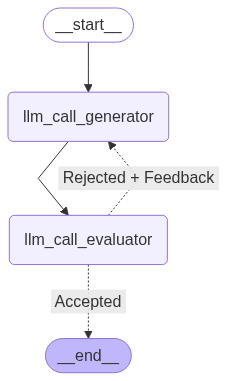

Why did the cat sit on the computer?  

Because it wanted to keep an eye on the mouse!


In [75]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

# ReAct (Reasoning and Acting)

## Use Case:
Interactive tasks needing reasoning, tool use, and adaptation to environmental feedback.

## Structure:
The model alternates between reasoning and acting (e.g., using tools), iterating until the goal is achieved.

## Why Use It:
Ideal for dynamic environments requiring flexible decision-making and real-time interaction.

![ReAct](https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F58d9f10c985c4eb5d53798dea315f7bb5ab6249e-2401x1000.png&w=3840&q=75)

In [76]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

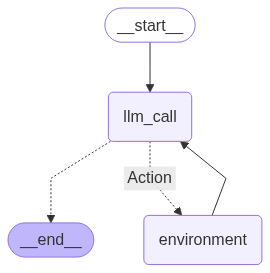

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_EP2kqFXGISriBCFdsHUPpZDk)
 Call ID: call_EP2kqFXGISriBCFdsHUPpZDk
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [41]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()